# Part 1: Email spam classification [25 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from glob import glob

directory_path = '/content/drive/MyDrive/Colab_Notebooks/email-dataset'
ham = glob(f"{directory_path}/ham/*.txt")
spam = glob(f"{directory_path}/spam/*.txt")
print('Ham count:',len(ham))
print('Spam count:',len(spam))

Mounted at /content/drive
Ham count: 1500
Spam count: 3671


This dataset is imbalanced. Spam emails are almost three times as many as Ham emails.

**Your answers to the above questions:**

**(b) Construct the documents [4 points]**

   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [2]:
import re
import string
import codecs

def make_word_list(path):

    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  #  (1)

    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)

    text = text.lower().split()           # -- (4)

    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [3]:
#your code here
documents = []
labels = []
for ham_file in ham:
    documents.append(make_word_list(ham_file))
    labels.append(0)
for spam_file in spam:
    documents.append(make_word_list(spam_file))
    labels.append(1)

**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [4]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(min_df=50, stop_words="english", max_df=0.8)
# Fit the vectorizer to the documents and transform the documents into the document-term matrix X
X = vectorizer.fit_transform(documents)
# Print the size of the vocabulary
print("Vocabulary size:", len(vectorizer.vocabulary_))
labels = np.array(labels)
len(labels)

Vocabulary size: 1680


5171

**(d) k-NN and random forest: Hyperparameter selection [5 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

best_k = None
best_cross_val_score = -np.inf  # assumes that a higher score is better

num_folds = 5
k_fold = KFold(num_folds,shuffle=True, random_state=0)
hyperparameter_settings = np.arange(1,6)

for i in hyperparameter_settings:
    f1_scores = []
    print("k = " + str(i))
    for k, (train, val) in enumerate(k_fold.split(X, labels)):
            clf = KNeighborsClassifier(n_neighbors=i)
            clf.fit(X[train], labels[train])

            ypred = clf.predict(X[val])
            yval = labels[val]
            a = f1_score(yval, ypred, average='weighted')
            f1_scores.append(a)
            print("\t[fold {0}] k: {1:.0f}, accuracy: {2:.5f}".format(k, i, a))

    cross_val_score = np.mean(f1_scores)
    print("\tMean F1 score: " + str(cross_val_score))

    if cross_val_score > best_cross_val_score:
        best_cross_val_score = cross_val_score
        best_k = i
print('Best k:', best_k)

k = 1
	[fold 0] k: 1, accuracy: 0.92728
	[fold 1] k: 1, accuracy: 0.93113
	[fold 2] k: 1, accuracy: 0.94634
	[fold 3] k: 1, accuracy: 0.93873
	[fold 4] k: 1, accuracy: 0.93136
	Mean F1 score: 0.9349663406063037
k = 2
	[fold 0] k: 2, accuracy: 0.90698
	[fold 1] k: 2, accuracy: 0.90062
	[fold 2] k: 2, accuracy: 0.94292
	[fold 3] k: 2, accuracy: 0.90338
	[fold 4] k: 2, accuracy: 0.90371
	Mean F1 score: 0.9115225116869805
k = 3
	[fold 0] k: 3, accuracy: 0.94561
	[fold 1] k: 3, accuracy: 0.95779
	[fold 2] k: 3, accuracy: 0.93857
	[fold 3] k: 3, accuracy: 0.93961
	[fold 4] k: 3, accuracy: 0.94700
	Mean F1 score: 0.9457175965030592
k = 4
	[fold 0] k: 4, accuracy: 0.93229
	[fold 1] k: 4, accuracy: 0.94771
	[fold 2] k: 4, accuracy: 0.91622
	[fold 3] k: 4, accuracy: 0.93615
	[fold 4] k: 4, accuracy: 0.94170
	Mean F1 score: 0.9348135140051349
k = 5
	[fold 0] k: 5, accuracy: 0.91700
	[fold 1] k: 5, accuracy: 0.92402
	[fold 2] k: 5, accuracy: 0.90783
	[fold 3] k: 5, accuracy: 0.91860
	[fold 4] k: 5

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

num_folds = 5
k_fold = StratifiedKFold(num_folds, shuffle=True)
param_values = [(max_features, min_samples_leaf)
                  for max_features in [7,28,112]
                  for min_samples_leaf in [1, 2, 4]]
arg_max = -np.inf
best_arg = None
for max_features, min_samples_leaf in param_values:
    fold_scores = []
    print("max_features = " + str(max_features)
          + ', min_samples = ' + str(min_samples_leaf))
    for k, (train, val) in enumerate(k_fold.split(X, labels)):
        clf_rf = RandomForestClassifier(max_features=max_features,
                                     min_samples_leaf=min_samples_leaf,
                                     random_state=0)
        clf_rf.fit(X[train], labels[train])

        ypred = clf_rf.predict(X[val])
        yval = labels[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        # print("\t[fold {0}], accuracy: {2:.5f}".format(k,a))
        print("\t[fold {0}], accuracy: {1:.5f}".format(k, a))

    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))

    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_arg = (max_features, min_samples_leaf)

best_max_features, best_min_samples_leaf = best_arg
print('Best max features:', best_max_features)
print('Best min samples leaf:', best_min_samples_leaf)

max_features = 7, min_samples = 1
	[fold 0], accuracy: 0.98833
	[fold 1], accuracy: 0.98834
	[fold 2], accuracy: 0.99127
	[fold 3], accuracy: 0.98932
	[fold 4], accuracy: 0.98734
	Mean F1 score: 0.988922329055697
max_features = 7, min_samples = 2
	[fold 0], accuracy: 0.97555
	[fold 1], accuracy: 0.97351
	[fold 2], accuracy: 0.98440
	[fold 3], accuracy: 0.97652
	[fold 4], accuracy: 0.98144
	Mean F1 score: 0.9782832995335132
max_features = 7, min_samples = 4
	[fold 0], accuracy: 0.96356
	[fold 1], accuracy: 0.95031
	[fold 2], accuracy: 0.96851
	[fold 3], accuracy: 0.95740
	[fold 4], accuracy: 0.97351
	Mean F1 score: 0.9626572481145569
max_features = 28, min_samples = 1
	[fold 0], accuracy: 0.98742
	[fold 1], accuracy: 0.98934
	[fold 2], accuracy: 0.98446
	[fold 3], accuracy: 0.98643
	[fold 4], accuracy: 0.98934
	Mean F1 score: 0.9873975532138743
max_features = 28, min_samples = 2
	[fold 0], accuracy: 0.99031
	[fold 1], accuracy: 0.98243
	[fold 2], accuracy: 0.97657
	[fold 3], accuracy: 0

In [7]:
clf_knn = KNeighborsClassifier(n_neighbors=best_k)
clf_rf = RandomForestClassifier(max_features=best_max_features, min_samples_leaf=best_min_samples_leaf)

clf_knn.fit(X, labels)
clf_rf.fit(X, labels)

RandomForestClassifier(max_features=7)

In [8]:
test_files = glob('/content/drive/MyDrive/Colab_Notebooks/email-dataset/testing/*.txt')
documents_test = []
labels_test = []
for file in test_files:
    documents_test.append(make_word_list(file))
    if file.find("ham") != -1:
        labels_test.append(0)
    else:
        labels_test.append(1)

Xtest = CountVectorizer(vocabulary=vectorizer.vocabulary_).fit_transform(documents_test)

In [9]:
ypred_knn = clf_knn.predict_proba(Xtest)[:,1]
ypred_rf = clf_rf.predict_proba(Xtest)[:,1]

**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

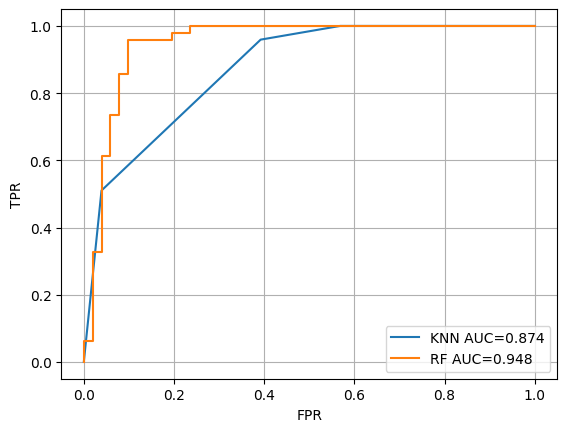

In [10]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure()
fpr, tpr, _ = roc_curve(labels_test, ypred_knn, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="KNN AUC=" + "{:.3f}".format(auc))

fpr, tpr, _ = roc_curve(labels_test, ypred_rf, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="RF AUC=" + "{:.3f}".format(auc))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show()

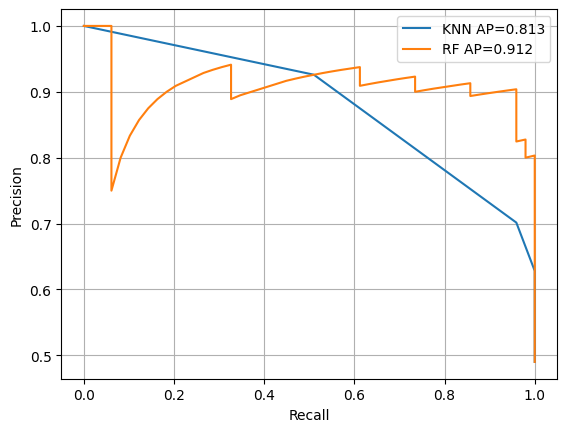

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure()
p, r, _ = precision_recall_curve(labels_test, ypred_knn, pos_label=1)
ap = average_precision_score(labels_test, ypred_knn)
plt.plot(r, p, label="KNN AP=" + "{:.3f}".format(ap))

p, r, _ = precision_recall_curve(labels_test, ypred_rf, pos_label=1)
ap = average_precision_score(labels_test, ypred_rf)
plt.plot(r, p, label="RF AP=" + "{:.3f}".format(ap))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend()
plt.show()

**Your answers to the above questions:**
I would use the ROC graph rather than the precision /recall graph. In the ROC graph, the bigger the area under the curve, the better the model is. The random forest model is better than the KNN model. In the second graph, the area under the curve isn't obevious which one is bigger.

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

In [12]:
!cp /content/drive/MyDrive/Colab_Notebooks/UDA_pytorch_utils.py /content
!pip install torchinfo

Let's start with some imports.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

100%|██████████| 26421880/26421880 [00:02<00:00, 12338615.46it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204260.75it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3966388.14it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17874401.48it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



<ipython-input-14-35012220dad7>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_images = torch.tensor([image.numpy() for image, label in train_dataset])


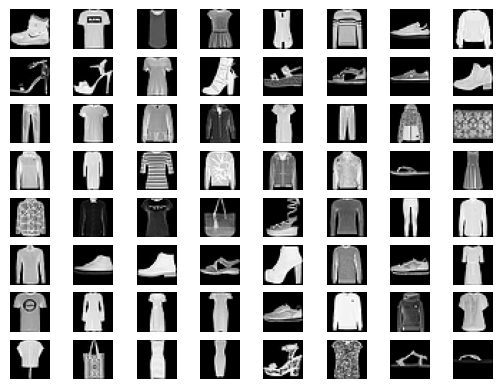

In [14]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

In [15]:
test_dataset.targets[0]

tensor(9)

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [16]:
mask = (train_labels == 2) | (train_labels == 6)
x_train = train_images[mask]
y_train = 1*(train_labels[mask] == 6)

mask = (test_labels == 2) | (test_labels == 6)
x_test = test_images[mask]
y_test = 1*(test_labels[mask] == 6)

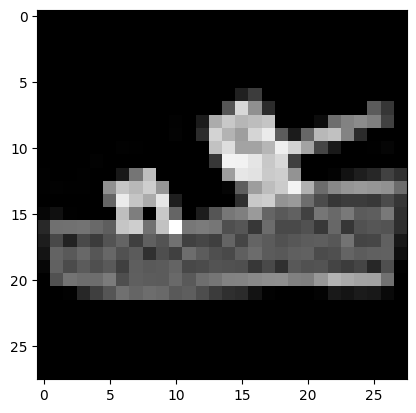

In [17]:
plt.imshow(train_images[12][0], cmap='gray')

In [18]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


In [19]:
x_train_np = x_train.numpy().reshape(x_train.shape[0],-1)
y_train_np = y_train.numpy()
x_test_np = x_test.numpy().reshape(x_test.shape[0],-1)
y_test_np = y_test.numpy()

We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [20]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]
# Subsample the data
x_train_small=x_train[random_sample]
x_train_small_np = x_train_np[random_sample]
y_train_small_np = y_train_np[random_sample]

**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [21]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/pretrained_convnet.pt',map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
print(summary(convnet, input_data=torch.zeros((1, 1, 28, 28))))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
print(summary(intermediate_layer_model, input_data=torch.zeros((1, 1, 28, 28))))

[Summary of pre-trained convnet]
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 26, 26]            60
├─ReLU: 1-2                              [1, 6, 26, 26]            --
├─MaxPool2d: 1-3                         [1, 6, 13, 13]            --
├─Conv2d: 1-4                            [1, 16, 11, 11]           880
├─ReLU: 1-5                              [1, 16, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Flatten: 1-7                           [1, 400]                  --
├─Linear: 1-8                            [1, 120]                  48,120
├─ReLU: 1-9                              [1, 120]                  --
├─Linear: 1-10                           [1, 84]                   10,164
├─ReLU: 1-11                             [1, 84]                   --
├─Linear: 1-12                           [1

In [22]:
predicted_test_labels = UDA_pytorch_classifier_predict(convnet, test_images)
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_dataset.targets))

Test accuracy: 0.8803


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [23]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.887619
[t-SNE] KL divergence after 1000 iterations: 1.063736


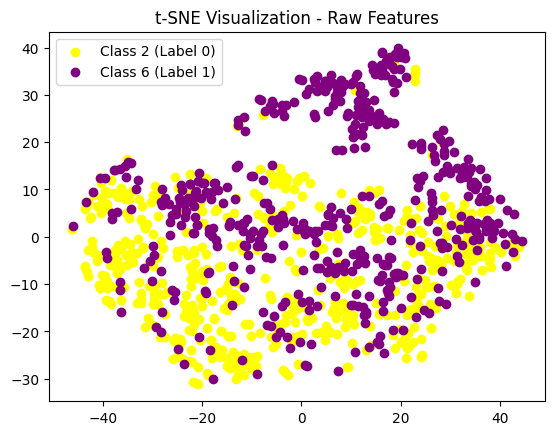

CPU times: user 13.1 s, sys: 266 ms, total: 13.3 s
Wall time: 8.23 s


In [24]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=25,verbose=1, random_state=0)
tsne_result = tsne.fit_transform(x_train_small_np)
plt.scatter(tsne_result[y_train_small_np == 0, 0], tsne_result[y_train_small_np == 0, 1], c='yellow', label='Class 2 (Label 0)')
plt.scatter(tsne_result[y_train_small_np == 1, 0], tsne_result[y_train_small_np == 1, 1], c='purple', label='Class 6 (Label 1)')
plt.title("t-SNE Visualization - Raw Features")
plt.legend()
plt.show()

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.685600
[t-SNE] KL divergence after 1000 iterations: 0.991148


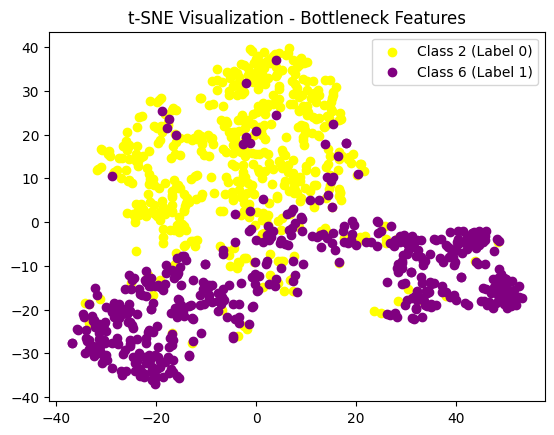

In [25]:
# write your code here
# Convert PyTorch tensor to NumPy array
x_train_small_bottleneck_np = x_train_small_bottleneck_representation.cpu().numpy()
x_train_small_bottleneck_np = x_train_small_bottleneck_representation.cpu().numpy()
tsne_bn = tsne.fit_transform(x_train_small_bottleneck_np)
plt.scatter(tsne_bn[y_train_small_np == 0, 0], tsne_bn[y_train_small_np == 0, 1], c='yellow', label='Class 2 (Label 0)')
plt.scatter(tsne_bn[y_train_small_np == 1, 0], tsne_bn[y_train_small_np == 1, 1], c='purple', label='Class 6 (Label 1)')
plt.legend()
plt.title("t-SNE Visualization - Bottleneck Features")
plt.show()

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy. Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |     0.880           | this cell stays empty|
| 5-NN             |     0.819           |      0.877           |
| Random forest    |     0.853           |      0.896            |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [26]:
from sklearn.neighbors import KNeighborsClassifier
raw_knn = KNeighborsClassifier(n_neighbors=5)
raw_knn.fit(x_train_small_np, y_train_small_np)
raw_knn_test_labels = raw_knn.predict(x_test_np)
raw_knn_score = np.mean(raw_knn_test_labels == np.array(y_test_np))
print('Raw 5NN score is', raw_knn_score)

Raw 5NN score is 0.819


In [27]:
from sklearn.metrics import accuracy_score
knn_bottleneck = KNeighborsClassifier(n_neighbors=5)
knn_bottleneck.fit(x_train_small_bottleneck_representation.cpu() , y_train_small_np)

# Predict on the test set using the 5-NN classifier trained on bottleneck features
x_test_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)
y_pred_bottleneck = knn_bottleneck.predict(x_test_small_bottleneck_representation.cpu())

# Calculate accuracy for the 5-NN classifier trained on bottleneck features
accuracy_bottleneck = accuracy_score(y_test_np, y_pred_bottleneck)
print("Accuracy (5-NN on bottleneck features):", accuracy_bottleneck)

Accuracy (5-NN on bottleneck features): 0.877


In [28]:
from sklearn.ensemble import RandomForestClassifier
raw_rf = RandomForestClassifier(n_estimators=100,random_state=0)
raw_rf.fit(x_train_small_np, y_train_small_np)
raw_rf_test_labels = raw_rf.predict(x_test_np)
raw_rf_score = np.mean(raw_rf_test_labels == np.array(y_test_np))
print('Raw Random Forest score is', raw_rf_score)

Raw Random Forest score is 0.8525


In [29]:
rf_bottleneck = RandomForestClassifier(n_estimators=100, random_state=0)
rf_bottleneck.fit(x_train_small_bottleneck_representation.cpu() , y_train_small_np)

# Predict on the test set using the random forest classifier trained on bottleneck features
y_pred_bottleneck_rf = rf_bottleneck.predict(x_test_small_bottleneck_representation.cpu())

# Calculate accuracy for the random forest classifier trained on bottleneck features
accuracy_bottleneck_rf = accuracy_score(y_test, y_pred_bottleneck_rf)
print("Accuracy (Random Forest on bottleneck features):", accuracy_bottleneck_rf)

Accuracy (Random Forest on bottleneck features): 0.8955


Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 5-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

**Write your answers here:**
The convnet model performed the best. The 5NN model showed the lowest accuracy. The 5NN and random forest classifiers' prediction accuracy are a little lower with raw features than the bottleneck features.

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

In [30]:
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)

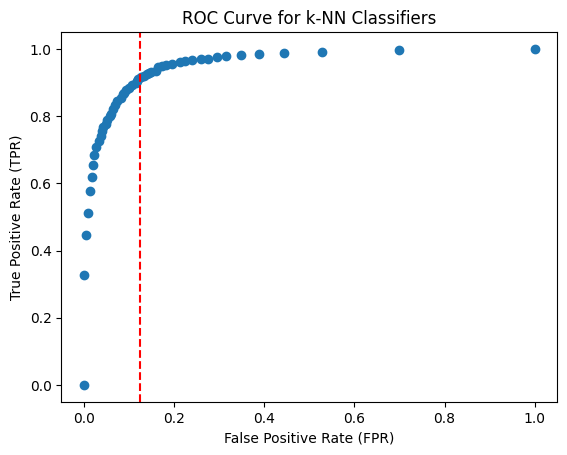

In [31]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Train k-NN classifiers with different k values
for k in range(1, 51):
    # Train k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_bottleneck_representation.cpu(), y_train_np)

    y_score = knn.predict_proba(x_test_small_bottleneck_representation.cpu()) #probabilistic classifier, so the model outputs probabilities
    fpr, tpr, thresholds = roc_curve(y_test_np, y_score[:,1], pos_label=1)
    auc = np.trapz(tpr, fpr)

# Plotting the scatter plot
plt.scatter(fpr, tpr)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for k-NN Classifiers')
vertical_line_x = 0.125

# Draw the vertical line
plt.axvline(x=vertical_line_x, color='r', linestyle='--')
plt.show()

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:**

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

k_values = range(1, 51)
best_k = 0
best_tpr = 0

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_bottleneck_representation.cpu(), y_train_np)

    # Make predictions on the validation set
    y_pred = knn.predict(x_test_small_bottleneck_representation.cpu())

    # Calculate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate the true positive rate (TPR) and false positive rate (FPR)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    # Check if the current k value achieves a higher TPR while maintaining a FPR below 12.5%
    if tpr > best_tpr and fpr <= 0.125:
        best_k = k
        best_tpr = tpr

# Print the optimal k value and its corresponding true positive rate
print("Optimal k value:", best_k)
print("True Positive Rate:", best_tpr)

Optimal k value: 11
True Positive Rate: 0.903


# Part 3: Sentiment Analysis [35 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

**We intentionally wrote this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.** We will give full credit even if you subsample the training data. For example, you only work with 5000 randomly chosen training tweets instead of all of them (over 1 million tweets). Also, for the random forest part (the last part), you can keep track of only the most frequently occurring 1000 words (again, this is enough for full credit) and you can also set the RandomForestClassifier argument "n_jobs" to -1 to use all your CPU threads. However, do not subsample the test dataset (which is small anyways).

If you want to have practice with what it's like working with a sizable dataset though, we do encourage you to try to use as much of the training data as possible (our solution code uses the full training data in an 80-20 split between a proper training set and a validation set, just like in lectures). Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions:

- Using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. As a suggestion, make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. As another suggestion, make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

- For the last part, training a random forest for sentiment analysis could be very computationally expensive. If you are already subsampling the training data beforehand, then great, just work with a smaller dataset (note: you should use the same training data for both the LSTM and for the random forest so that the comparison between them is fair). If you want to still try to use the full training dataset or as much of it as possible, then we suggest that you represent the feature vectors as a sparse matrix. You might also want to set the "max_samples" argument to be something like 0.1 so that each tree uses a 10% subsample of the proper training set (with the default choice of 100 trees, across all your trees, you will likely use the vast majority of the full training set---it's just that each tree won't look at more than 10% of the proper training set). Also, simple data splitting suffices; cross-validation here would be very expensive. Moreover, it's fine to not train a random forest from scratch using the best hyperparameters found; instead just use whichever model was trained using the proper training data with the best hyperparameters found.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # to help make code deterministic

from glob import glob

import torch
torch.use_deterministic_algorithms(True)  # to help make code deterministic
torch.backends.cudnn.benchmark = False  # to help make code deterministic
import torch.nn as nn
from torchinfo import summary

np.random.seed(0)  # to help make code deterministic
torch.manual_seed(0)  # to help make code deterministic
random.seed(0)  # to help make code deterministic

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy, UDA_get_rnn_last_time_step_outputs

In [34]:
def read_data(csv_filename):
    import pandas as pd
    df = pd.read_csv(csv_filename, header=None, encoding='iso8859')

    df = df[df.columns[[0, 5]]]
    df.columns = ['Sentiment', 'Text']
    df = df[df.Sentiment.isnull() == False]
    df['Sentiment'] = df['Sentiment'].map(int)
    df = df[df['Text'].isnull() == False]
    df = df.sample(frac=1)
    print(df.head(3))
    df.groupby('Sentiment').count()
    return df

df = read_data('/content/drive/MyDrive/Colab_Notebooks/HW3-data/train.csv')

        Sentiment                                               Text
557138          0  wants to compete! i want hard competition! i w...
349381          0  It seems we are stuck on the ground in Amarill...
182051          0  where the f are my pinking shears? rarararrrar...


In [35]:
positive_count = df['Sentiment'].value_counts()[1]
negative_count = df['Sentiment'].value_counts()[0]
print("Number of positive sentiment labels:", positive_count)
print("Number of negative sentiment labels:", negative_count)

Number of positive sentiment labels: 800000
Number of negative sentiment labels: 800000


In [36]:
texts = list(df['Text'].head(5000))
labels = df['Sentiment'].head(5000)
train_data=list(zip(texts,labels))
labels=np.array(labels)

In [37]:
train_len = int(len(train_data) * 0.8)
val_len = len(train_data) - train_len
print('# proper training data points:', train_len)
print('# validation data points:', val_len)
x_train, x_val = torch.utils.data.random_split(train_data,[train_len, val_len])

# proper training data points: 4000
# validation data points: 1000


In [38]:
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def tokenizer_lowercase(text):
    return [token.lower() for token in tokenizer(text)]
x_train_tokens_without_labels = [tokenizer_lowercase(text) for text, label in x_train]

In [39]:
from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(x_train_tokens_without_labels,specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab(tokenizer_lowercase(x_train[0][0]))
vocab.lookup_token(1259)

'glasses'

In [40]:
proper_train_encoded = [vocab(tokens) for tokens in x_train_tokens_without_labels]
proper_train_encoded[0]
proper_train_labels = [label for text, label in x_train]
val_encoded = [vocab(tokenizer_lowercase(text)) for text, label in x_val]
val_labels = [label for text, label in x_val]
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

**(b) [20 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [41]:
from torchtext.vocab import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)
embedding_matrix = torch.zeros(len(vocab), pretrained_embedding.dim)
for i, token in enumerate(vocab.lookup_tokens(range(len(vocab)))):
    embedding_matrix[i] = pretrained_embedding[token]

.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18854.73it/s]


In [42]:
class EmbeddingLSTMLinearModel(nn.Module):
    def __init__(self, embedding_matrix, num_lstm_output_nodes, num_final_output_nodes):
        super().__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
        self.lstm_layer = nn.LSTM(embedding_matrix.shape[1], num_lstm_output_nodes)
        self.linear_layer = nn.Linear(num_lstm_output_nodes, num_final_output_nodes)

    def forward(self, text_encodings, lengths):
        embeddings = self.embedding_layer(text_encodings)

        rnn_last_time_step_outputs = \
            UDA_get_rnn_last_time_step_outputs(embeddings, lengths, self.lstm_layer)

        return self.linear_layer(rnn_last_time_step_outputs)

In [43]:
simple_lstm_model = EmbeddingLSTMLinearModel(embedding_matrix, 32, 2)
summary(simple_lstm_model,
        input_data=[torch.zeros((7, 5), dtype=torch.long),
                    torch.tensor([3, 2, 5, 1, 7], dtype=torch.long)])

Layer (type:depth-idx)                   Output Shape              Param #
EmbeddingLSTMLinearModel                 [5, 2]                    --
├─Embedding: 1-1                         [7, 5, 100]               (1,019,700)
├─LSTM: 1-2                              [18, 32]                  17,152
├─Linear: 1-3                            [5, 2]                    66
Total params: 1,036,918
Trainable params: 17,218
Non-trainable params: 1,019,700
Total mult-adds (M): 17.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.15
Estimated Total Size (MB): 4.18

In [44]:
os.makedirs('./saved_model_checkpoints', exist_ok=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  Train accuracy: 0.6757
  Validation accuracy: 0.6620


 10%|█         | 1/10 [00:01<00:17,  1.94s/it]

  Train accuracy: 0.7245
  Validation accuracy: 0.7070


 20%|██        | 2/10 [00:02<00:09,  1.24s/it]

  Train accuracy: 0.7592
  Validation accuracy: 0.7270


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

  Train accuracy: 0.7772
  Validation accuracy: 0.7180


 40%|████      | 4/10 [00:04<00:05,  1.08it/s]

  Train accuracy: 0.8145
  Validation accuracy: 0.7290


 50%|█████     | 5/10 [00:05<00:04,  1.15it/s]

  Train accuracy: 0.8455
  Validation accuracy: 0.7200


 60%|██████    | 6/10 [00:05<00:03,  1.20it/s]

  Train accuracy: 0.8758
  Validation accuracy: 0.7090


 70%|███████   | 7/10 [00:06<00:02,  1.23it/s]

  Train accuracy: 0.8860
  Validation accuracy: 0.7110


 80%|████████  | 8/10 [00:07<00:01,  1.25it/s]

  Train accuracy: 0.8842
  Validation accuracy: 0.6950


 90%|█████████ | 9/10 [00:08<00:00,  1.27it/s]

  Train accuracy: 0.9237
  Validation accuracy: 0.7130


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


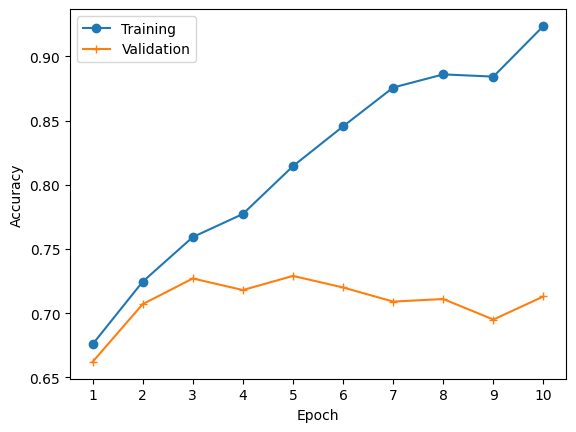

In [45]:
num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 100  # during optimization, how many training data to use at each step
learning_rate = 0.005  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               rnn=True,
                               save_epoch_checkpoint_prefix='./saved_model_checkpoints/imdb_lstm')

UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)
best_epoch_idx = np.argmax(val_accuracies)

In [46]:
print('The model at the end of epoch %d achieved the highest validation accuracy: %f'
      % (best_epoch_idx + 1, val_accuracies[best_epoch_idx]))
simple_lstm_model.load_state_dict(torch.load('./saved_model_checkpoints/imdb_lstm_epoch%d.pt' % (best_epoch_idx + 1)))

The model at the end of epoch 5 achieved the highest validation accuracy: 0.729000


<All keys matched successfully>

**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [47]:
# your code here
test_df = read_data('/content/drive/MyDrive/Colab_Notebooks/HW3-data/test.csv')
test_texts = list(test_df['Text'])
test_labels = test_df['Sentiment']
test_dataset =list(zip(test_texts, test_labels))
test_dataset[:3]
# test_dataset = np.array(test_dataset)

     Sentiment                                               Text
98           0  Higher physics exam tommorow, not lookin forwa...
127          1  just got back from the movies.  went to see th...
446          0  jquery Selectors http://codylindley.com/jquery...


[('Higher physics exam tommorow, not lookin forward to it much :(', 0),
 ('just got back from the movies.  went to see the new night at the museum with rachel.  it was good',
  1),
 ('jquery Selectors http://codylindley.com/jqueryselectors/', 0)]

In [48]:
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
test_encoded = [vocab(tokenizer(text)) for text, label in test_dataset]
test_labels = [label for text, label in test_dataset]
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       rnn=True)
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.5461847389558233


In [49]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words="english", max_df=0.8)
# Fit the vectorizer to the documents and transform the documents into the document-term matrix X
X = vectorizer.fit_transform(texts)

In [50]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

num_folds = 5
k_fold = StratifiedKFold(num_folds, shuffle=True)
param_values = [(n_estimators, max_depth)
                for n_estimators in [50,100]
                for max_depth in [25,50,75]]

arg_max = -np.inf
best_arg = None
for n_estimators, max_depth in param_values:
    fold_scores = []
    print("n_estimators = " + str(n_estimators)
          + ', max_depth = ' + str(max_depth))
    for k, (train, val) in enumerate(k_fold.split(X, labels)):
        clf_rf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     random_state=0)
        clf_rf.fit(X[train], labels[train])

        ypred = clf_rf.predict(X[val])
        yval = labels[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        # print("\t[fold {0}], accuracy: {1:.5f}".format(k, a))

    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))

    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_arg = (n_estimators, max_depth)

best_n_estimators, best_max_depth = best_arg
print('Best n_estimators:', best_n_estimators)
print('Best max_depth:', best_max_depth)

n_estimators = 50, max_depth = 25
	Mean F1 score: 0.6872342271687858
n_estimators = 50, max_depth = 50
	Mean F1 score: 0.6947061088752416
n_estimators = 50, max_depth = 75
	Mean F1 score: 0.6827388496459583
n_estimators = 100, max_depth = 25
	Mean F1 score: 0.6834690502964487
n_estimators = 100, max_depth = 50
	Mean F1 score: 0.6928119086848434
n_estimators = 100, max_depth = 75
	Mean F1 score: 0.6904507205818663
Best n_estimators: 50
Best max_depth: 50


In [51]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

num_folds = 5
k_fold = StratifiedKFold(num_folds, shuffle=True)
param_values = [(max_features, min_samples_leaf)
                  for max_features in [7,28,112]
                  for min_samples_leaf in [1, 2, 4]]

arg_max = -np.inf
best_arg = None
for max_features, min_samples_leaf in param_values:
    fold_scores = []
    print("max_features = " + str(max_features)
          + ', min_samples_leaf = ' + str(min_samples_leaf))
    for k, (train, val) in enumerate(k_fold.split(X, labels)):
        clf_rf = RandomForestClassifier(max_features=max_features,
                                     min_samples_leaf=min_samples_leaf,
                                     random_state=0)
        clf_rf.fit(X[train], labels[train])

        ypred = clf_rf.predict(X[val])
        yval = labels[val]
        a = f1_score(yval, ypred, average='weighted')
        fold_scores.append(a)
        # print("\t[fold {0}], accuracy: {1:.5f}".format(k, a))

    cross_val_score = np.mean(fold_scores)
    print("\tMean F1 score: " + str(cross_val_score))

    if cross_val_score > arg_max:
        arg_max = cross_val_score
        best_arg = (max_features, min_samples_leaf)

max_features, min_samples_leaf = best_arg
print('Best max_features:', max_features, )
print('Best min_samples_leaf:', min_samples_leaf)

max_features = 7, min_samples_leaf = 1
	Mean F1 score: 0.6931594364439554
max_features = 7, min_samples_leaf = 2
	Mean F1 score: 0.7100634158984155
max_features = 7, min_samples_leaf = 4
	Mean F1 score: 0.7026642862990312
max_features = 28, min_samples_leaf = 1
	Mean F1 score: 0.6876359405057823
max_features = 28, min_samples_leaf = 2
	Mean F1 score: 0.6951321300950812
max_features = 28, min_samples_leaf = 4
	Mean F1 score: 0.6941870067860857
max_features = 112, min_samples_leaf = 1
	Mean F1 score: 0.6806966857745824
max_features = 112, min_samples_leaf = 2
	Mean F1 score: 0.6948067373443325
max_features = 112, min_samples_leaf = 4
	Mean F1 score: 0.692118462647563
Best max_features: 7
Best min_samples_leaf: 2


In [52]:
best_model = RandomForestClassifier(max_features=max_features,
                                min_samples_leaf=min_samples_leaf)
best_model.fit(X, labels)

RandomForestClassifier(max_features=7, min_samples_leaf=2)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
test_features = vectorizer.transform(test_texts)

In [54]:
test_labels=np.array(test_labels)
predicted_labels = best_model.predict(test_features)

# Calculate the accuracy of the model
accuracy = accuracy_score(test_labels, predicted_labels)

# Print the accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.5662650602409639
